In [50]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [51]:
! kaggle datasets download -d danrasband/asl-alphabet-test

asl-alphabet-test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
! unzip /content/asl-alphabet-test.zip

Archive:  /content/asl-alphabet-test.zip
replace A/A0001_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [53]:
!pip install rembg

In [54]:
!pip install --upgrade scikit-learn

In [55]:
! pip install tensorflow

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import PIL
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.preprocessing import image

import os
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import cv2
import sys

In [57]:
from tensorflow.python.keras.layers import Input, Dense, Flatten, Lambda, Dropout

In [58]:
import pathlib
data_dir = "/content/asl-alphabet-test"
data_dir = pathlib.Path(data_dir)

In [59]:
from PIL import Image
# Load the image and convert it to grayscale
img1 = Image.open('/content/2-Figure1-1.png').convert('L') #we input here the path
img2 = Image.open('/content/الأبجدية_العربية_بلغة_الإشارة_(Arabic_Alphabet_in_Sign_Language).jpg').convert('L') #we input here the path

# Convert the image to a numpy array
img_arr1 = np.asarray(img1)
img_arr2 = np.asarray(img2)

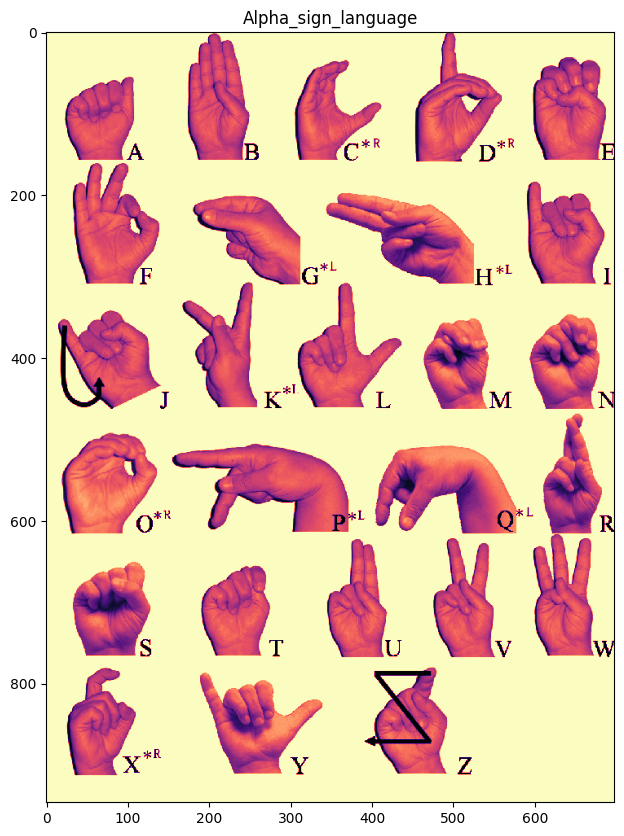

In [60]:
fig,ax= plt.subplots(figsize=(10, 10))
ax.imshow(img_arr1, cmap='magma')
ax.set_title('Alpha_sign_language')
plt.show()

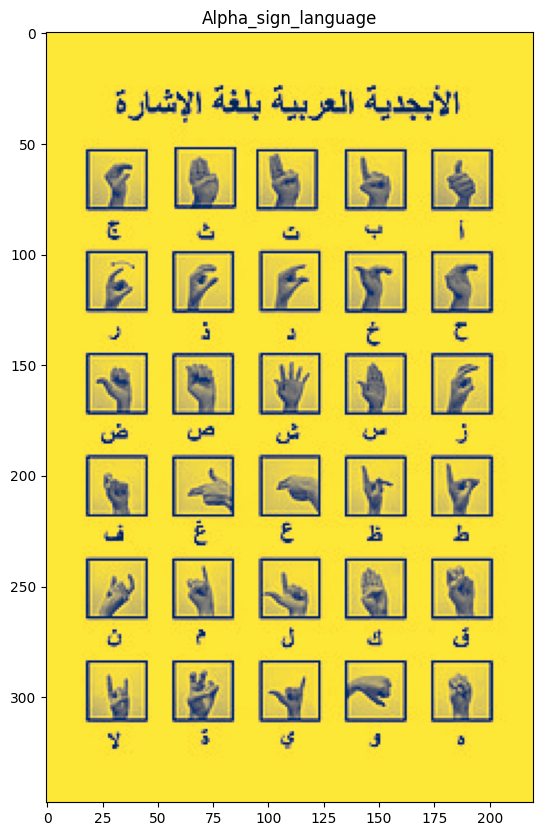

In [61]:
fig,ax= plt.subplots(figsize=(10, 10))
ax.imshow(img_arr2, cmap='cividis')
ax.set_title('Alpha_sign_language')
plt.show()

In [62]:
# ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (180, 180),
                                           batch_size=32,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (180, 180),
                                     batch_size=32,
                                          subset='validation',
                                     seed=46)

Found 696 images belonging to 29 classes.
Found 174 images belonging to 29 classes.


In [63]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

In [64]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=35,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [65]:
# Fully Connected Layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(26, activation='softmax'))

In [66]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 26)               13338     
 pper)                                                           
                                                                 
Total params: 24,650,138
Trainable params: 1,062,426
Non-trainable params: 23,587,712
__________________________________

In [67]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics = ['accuracy',f1, precision,recall])

# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, initial_lr):
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * np.exp(-0.1 * (epoch - 9))

model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mse')
round(model.optimizer.lr.numpy(), 5)

initial_lr = model.optimizer.lr.numpy()

for epoch in range(15):
    lr = scheduler(epoch, initial_lr)
    model.optimizer.lr.assign(lr)
    history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5), epochs=1, verbose=0)

round(model.optimizer.lr.numpy(), 5)

0.06065

1/1 [==============================] - 4s 4s/step


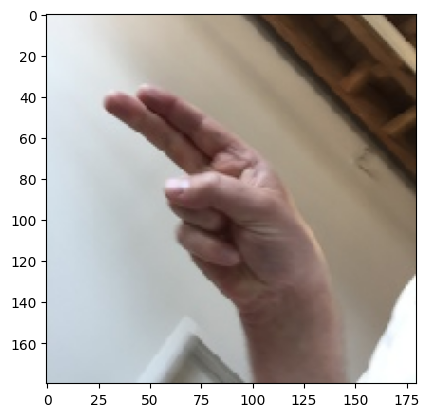

In [68]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
import keras.utils as image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("/content/H/H0001_test.jpg", target_size=(180, 180))
x = image.img_to_array(img)
plt.imshow(img )
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = resnet_model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
# pred_class

In [69]:
Y_pred = resnet_model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

In [70]:
from tensorflow.keras import backend as K
import tensorflow as tf

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

resnet_model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
resnet_model.compile(optimizer='sgd', loss='mse', metrics=[precision, recall, f1])

In [71]:
labels = val_ds.classes
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.04      0.17      0.07         6
           8       0.15      0.67      0.24         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         6
          17       0.00    